### Python for street networks

Retrieve, construct, analyze, and visualize street networks from OpenStreetMap

Code at Github: https://github.com/gboeing/osmnx

For the function docs: https://osmnx.readthedocs.io/en/stable/osmnx.html

For a nice intro on his blog: http://geoffboeing.com/2016/11/osmnx-python-street-networks/

### the basics

OSMnx is a Python package that lets you download **spatial geometries** and construct, project, visualize, and analyze street networks from OpenStreetMap's APIs. Users can download and construct walkable, drivable, or bikable urban networks with a single line of Python code, and then easily analyze and visualize them:

In [65]:
# get the modules
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import osmnx as ox
import networkx as nx

from sklearn.neighbors import KDTree
import folium
ox.config(use_cache=True, log_console=True)
print (ox.__version__)
print (nx.__version__)

# paths
OUTPUT_PATH = '../images/'

0.8.1
2.1


In [39]:
# graph figure settings
graph_settings = {'fig_height' :10, 
                  'fig_width' :12, 
                  'node_color' :'#F42334',
                  'edge_color' :'#253F51', 
                  'edge_alpha' :.5, 
                  'node_alpha' : 1}

arrow_settings = {'arrowstyle' :"->", 
                 'connectionstyle' : "angle3,angleA=0,angleB=-90",
                 'color': '#49a347'}
bbox_settings = {'boxstyle': "round4,pad=.5", 'fc': "0.9"}

# https://www.colorbook.io/colorschemes

## Create a networkx graph 

**graph_from_place** from OSM data within the spatial boundaries of some geocodable place(s)

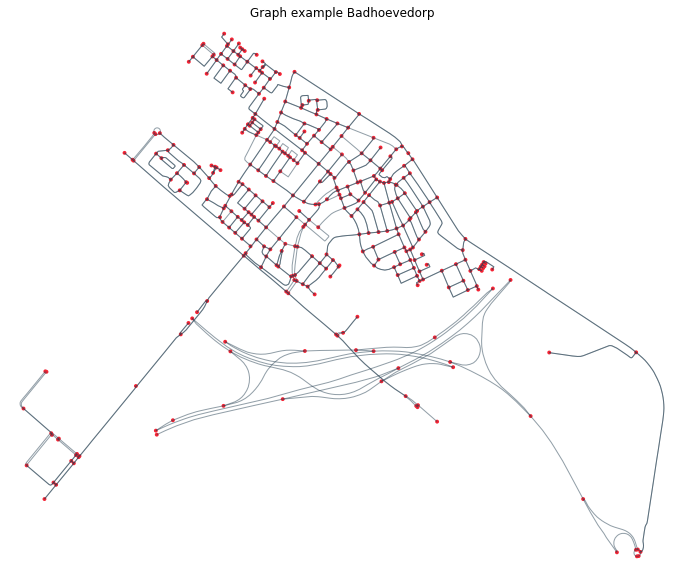

In [7]:
G = ox.graph_from_place('badhoevedorp, Netherlands', network_type='drive')
fig, ax = ox.plot_graph(ox.project_graph(G), show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example Badhoevedorp')

## steps --
## --> graph_from_place --> project_graph UTM = Universele transversale mercatorprojectie
## --> plot_graph

In [ ]:
# shortest path between 2 random nodes
route = nx.shortest_path(G, source = np.random.choice(G.nodes), target = 
                         np.random.choice(G.nodes))
fig, ax = ox.plot_graph_route(G, route, show=False, close=False, **graph_settings, 
                              route_color = '#49a347', route_alpha=1)
_ = ax.set(title = 'demo shortest path between 2 random nodes')

**graph_from_address** Create a networkx graph from OSM data within some distance of some address.

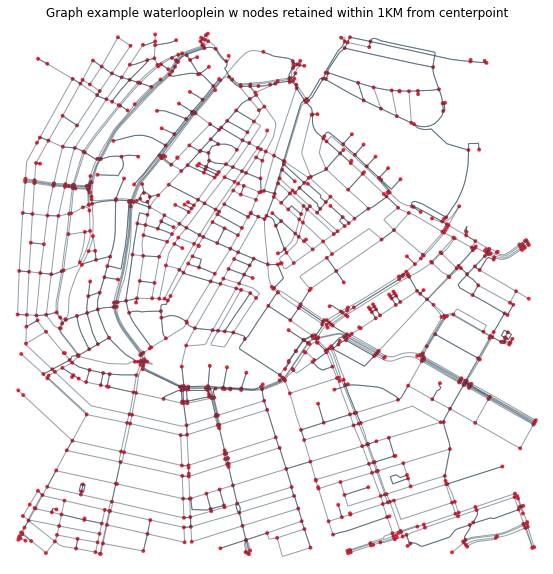

In [90]:
# get a street network and plot it with all edge intersections
address = 'waterlooplein, amsterdam'
G = ox.graph_from_address(address, network_type='bike', distance=1000)
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings)
_ = ax.set(title = 'Graph example waterlooplein w nodes retained within 1KM from centerpoint')

In [91]:
end = ox.geocode('oudezijds voorburgwal 300, amsterdam')
start = ox.geocode('Weesperstraat 113, Amsterdam')
print (end) # oz
print (start) #datalab

(52.3712198, 4.8953522)
(52.3630173, 4.9072382)


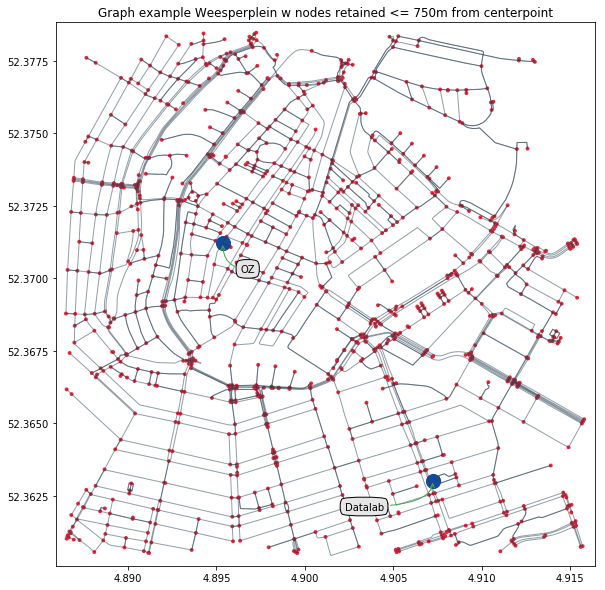

In [94]:
fig, ax = ox.plot_graph(G, show=False, close=False, **graph_settings, axis_off=False)
#annotate plot
_ = ax.set(title = 'Graph example Weesperplein w nodes retained <= 750m from centerpoint')
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)
ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
plt.show()

### convert a graph to a GeoDataFrame

In [95]:
nodes, _ = ox.graph_to_gdfs(G)
nodes.head()

,highway,osmid,ref,x,y,geometry
611250180,NaN,611250180,NaN,4.90179,52.3724,POINT (4.901792 52.3724093)
46383113,NaN,46383113,NaN,4.90169,52.3709,POINT (4.9016938 52.3709135)
3176714250,NaN,3176714250,NaN,4.89308,52.3733,POINT (4.8930775 52.3732675)
252100625,NaN,252100625,NaN,4.90501,52.3664,POINT (4.9050135 52.3663559)
2054127636,NaN,2054127636,NaN,4.90514,52.3782,POINT (4.9051441 52.3781753)


### KDTree for fast generalized N-point problems

A k-d tree makes finding our optimal nodes easy and efficient. The last two lines identify the Node IDs. (KD = Kernel Density)

In [103]:
tree.get_tree_stats()

(5, 1, 5)

In [117]:
tree = KDTree(nodes[['y', 'x']], metric='euclidean', leaf_size= 10)

start_idx = tree.query([start], k=1, return_distance=False)[0]
end_idx = tree.query([end], k=1, return_distance=False)[0]
closest_node_to_start = nodes.iloc[start_idx].index.values[0]
closest_node_to_end = nodes.iloc[end_idx].index.values[0]

route = nx.shortest_path(G, closest_node_to_start, closest_node_to_end)
print ('list of nodes between : {} and {} = {}'.format(start_idx, end_idx, route))

list of nodes between : [392] and [222] = [1825801483, 46346752, 46349945, 46351200, 46350963, 46348792, 46351322, 46354504, 46355782, 46360568, 1307649106, 46362733, 3907020119, 3907020120, 46363000, 3188225083, 25752666, 46369715, 46369862, 46370164, 46370468, 46377925, 725239288, 46379586, 46380375, 46381175, 318452533]


 **KD-tree search**
 
 - pick a random atrribute
 - for that attribute find the median and use this to split the dataset (half of datapoint on 1 side) = balanced data structure
 - continue this procedure 
 - use this to find your neigherst neighbours for a newly selected point (datalab / OZ data point in this case) --> find the regions of the data this Point geometry is contained in and compare to all Points in this region. Recursively select to suibtree to search in.

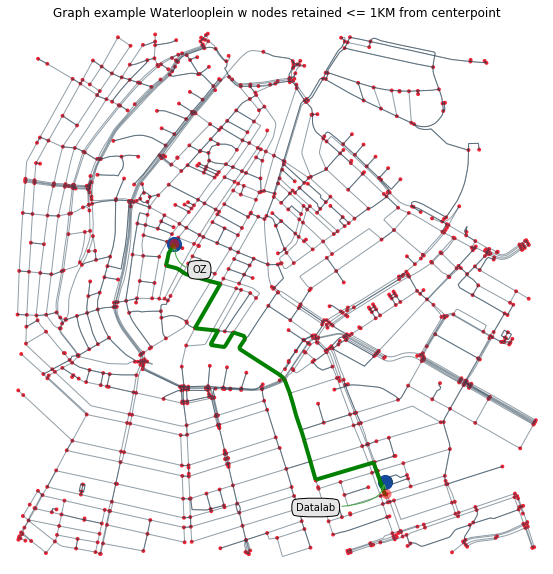

In [118]:
fig, ax = ox.plot_graph_route(G, route, show=False, close=False, **graph_settings,
                         route_color = 'green', route_alpha=1)
_ = ax.set(title = 'Graph example Waterlooplein w nodes retained <= 1KM from centerpoint')
ax.scatter(end[1], end[0], c='#144a9c', s=200)
ax.scatter(start[1], start[0], c='#144a9c', s=200)

ax.annotate('OZ', xy = (end[1], end[0]), 
            xytext=(end[1] +.001, end[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)
ax.annotate('Datalab', xy = (start[1], start[0]), 
            xytext=(start[1] -.005, start[0] -.001), bbox=bbox_settings, 
            arrowprops=arrow_settings)

plt.show()

In [119]:
m = ox.plot_route_folium(G, route, route_color='green')
folium.Marker(location=start,
              icon=folium.Icon(color='red'), popup='Datalab').add_to(m)
folium.Marker(location=end,
              icon=folium.Icon(color='blue'), popup='OZ').add_to(m)
m

### basic stats

Calculate basic descriptive metric and topological stats for a graph.

In [120]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

3772709.16784563

In [121]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.0228546489361068,
 'clean_intersection_count': 443,
 'clean_intersection_density_km': 117.42225024278004,
 'edge_density_km': 37000.60136883352,
 'edge_length_avg': 53.648158339738586,
 'edge_length_total': 139592.5079999998,
 'intersection_count': 1074,
 'intersection_density_km': 284.67606492267663,
 'k_avg': 4.318672199170124,
 'm': 2602,
 'n': 1205,
 'node_density_km': 319.39912312088023,
 'self_loop_proportion': 0.0,
 'street_density_km': 28209.56460335204,
 'street_length_avg': 57.52782864864855,
 'street_length_total': 106426.48299999982,
 'street_segments_count': 1850,
 'streets_per_node_avg': 3.166804979253112,
 'streets_per_node_counts': {0: 0,
  1: 131,
  2: 38,
  3: 562,
  4: 454,
  5: 14,
  6: 5,
  7: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.1087136929460581,
  2: 0.03153526970954357,
  3: 0.46639004149377594,
  4: 0.3767634854771784,
  5: 0.011618257261410789,
  6: 0.004149377593360996,
  7: 0.0008298755186721991}}

In [46]:
# save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
ox.save_graph_shapefile(G, filename='mynetwork_shapefile', folder = OUTPUT_PATH)
ox.save_graphml(G, filename='mynetwork.xml',folder= OUTPUT_PATH)

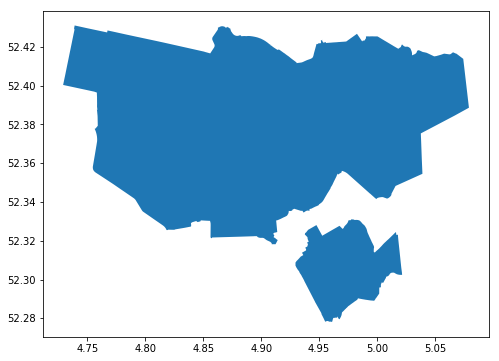

In [3]:
fig, ax = plt.subplots(figsize =[8,6])
ams.plot(ax=ax)

In [4]:
# get the street network within this bounding box
west, south, east, north = ams.unary_union.buffer(0.01).bounds
G = ox.graph_from_bbox(north, south, east, west, network_type='all', retain_all=True)

In [ ]:
# project the graph data in UTM format (Universal Transverse Mercator)
#graph_proj = ox.project_graph(G)

In [5]:
df_nodes, df_edges = ox.graph_to_gdfs(G, nodes=True, edges=True)

In [58]:
print ('df_nodes dataframe: {}'.format(df_nodes.shape))
print ('df_edges dataframe: {}'.format(df_edges.shape))

df_nodes dataframe: (74523, 6)
df_edges dataframe: (197554, 21)


Column	Description	Data type
- `bridge`	--> Bridge feature	boolean
- `geometry`	--> Geometry of the feature	Shapely.geometry
- `highway`	--> Tag for roads, paths (road type)	str (list if multiple)
- `lanes`	--> Number of lanes	int (or nan)
- `lenght`	--> The length of a feature in meters	float
- `maxspeed`	--> maximum legal speed limit	int (list if multiple)
- `name`	--> Name of the (street) element	str (or nan)
- `oneway`	--> Street is usable only in one direction	boolean
- `osmid`	--> Unique node ids of the element	list
- `u`	--> The first node of networkx edge tuple	int
- `v`	--> The last node of networkx edge tuple	int

Most of the attributes comes directly from the OpenStreetMap, however, columns `u` and `v` are networkx specific ids.

### cleaning

In [39]:
# highway Series contain lists. Get first element
df_edges['highway'] = [x[0] if isinstance(x, list) else x for x in df_edges['highway']]

In [55]:
# we remove motorway & motorway_link
df_edges = df_edges.query("highway != 'motorway_link' and highway != 'motorway' and \
highway != 'sservice' and highway != 'disused' and highway != 'elevator' \
and highway != 'escalator'")

In [56]:
df_edges.highway.value_counts()

footway           44785
unclassified      33649
cycleway          31495
service           26584
residential       25825
tertiary          10219
path               5613
pedestrian         5577
secondary          5344
living_street      2923
primary            1976
track              1832
steps               698
bridleway           454
primary_link        153
secondary_link      128
trunk_link          110
trunk               110
bus_stop             34
tertiary_link        25
crossing             12
road                  8
Name: highway, dtype: int64

In [62]:
df_edges['bridge'] = df_edges.bridge.fillna('no')

In [77]:
df_nodes.highway.value_counts(dropna=False)

NaN                  72632
crossing              1137
traffic_signals        509
motorway_junction      141
turning_circle          34
elevator                29
bus_stop                22
priority_to_right        8
mini_roundabout          6
give_way                 2
passing_place            2
stop                     1
Name: highway, dtype: int64

In [ ]:
# export the dataframes
df_nodes.to_csv(PATH + 'df_nodes.csv', index=False)
df_edges.to_csv(PATH + 'df_edges.csv', index=False)

### plot quality check

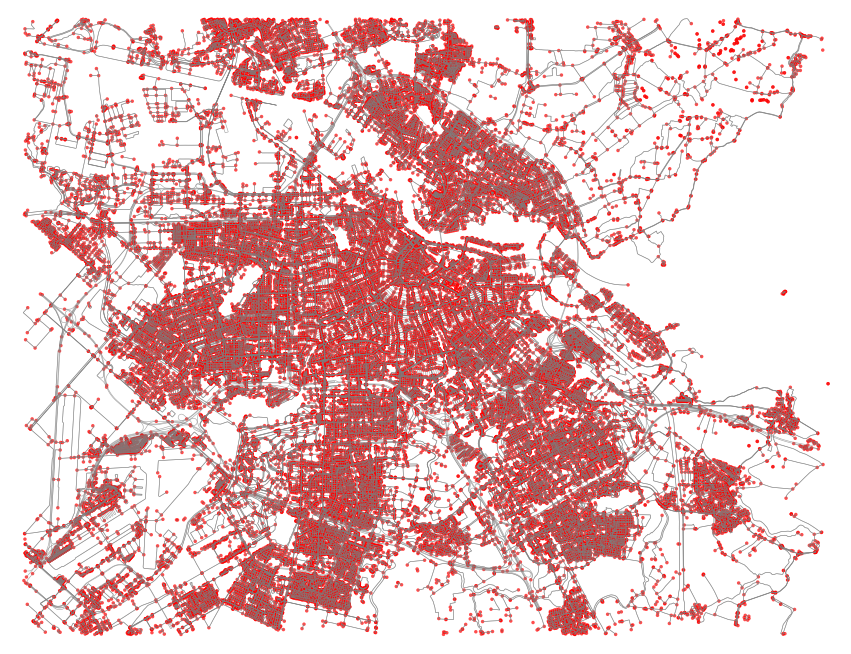

In [9]:
fig, ax = ox.plot_graph(G, fig_height=12, fig_width=15, node_color='red', node_size=12, 
                        node_alpha=.7 ,edge_color = 'grey', edge_linewidth=.6, 
                        edge_alpha=.7)

Here we 
For a projected graph, tolerance and graph units should be in meters (or similar) and circuity_dist should be ‘euclidean’. 

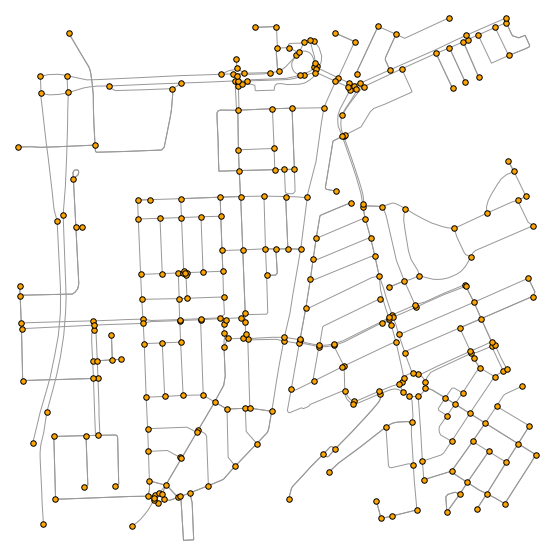

In [78]:
# get a street network and plot it with all edge intersections
address = 'legmeerplein, amsterdam'
G = ox.graph_from_address(address, network_type='drive', distance=750)
G_proj = ox.project_graph(G)
fig, ax = ox.plot_graph(G_proj, fig_height=10, node_color='orange', node_size=30, 
                        node_zorder=2, node_edgecolor='k')

**Clean up the intersections**

We'll specify that any nodes with 15 meters of each other in this network are part of the same intersection. Adjust this tolerance based on the street design standards in the community you are examining, and use a projected graph to work in meaningful units like meters. We'll also specify that we do not want dead-ends returned in our list of cleaned intersections. Then we extract their xy coordinates and plot it to show how the clean intersections below compare to the topological edge intersections above.

In [80]:
# clean up the intersections and extract their xy coords
import numpy as np
intersections = ox.clean_intersections(G_proj, tolerance=15, dead_ends=False)
points = np.array([point.xy for point in intersections])

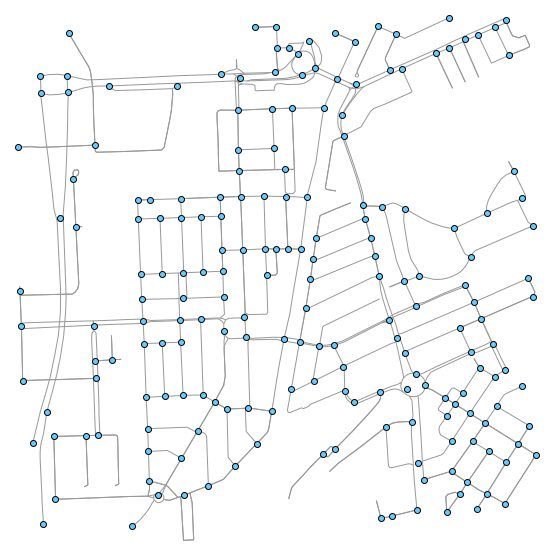

In [81]:
# plot the cleaned-up intersections
fig, ax = ox.plot_graph(G_proj, fig_height=10, show=False, close=False, node_alpha=0)
ax.scatter(x=points[:,0], y=points[:,1], zorder=2, color='#66ccff', edgecolors='k')
plt.show()

In [ ]:
### 

In [11]:
x, y = df_nodes['geometry'].unary_union.centroid.xy
center_node = ox.get_nearest_node(G, (y[0], x[0]))

In [17]:
network_type = 'walk'
trip_times = [5, 10, 15, 20, 25, 45, 60, 90] #in minutes
travel_speed = 4.5 #walking speed in km/hour

In [18]:
# add an edge attribute for time in minutes required to traverse each edge
meters_per_minute = travel_speed * 1000 / 60 #km per hour to m per minute
for u, v, k, data in G.edges(data=True, keys=True):
    data['time'] = data['length'] / meters_per_minute

In [19]:
# get one color for each isochrone
iso_colors = ox.get_colors(n=len(trip_times), cmap='Reds', start=0.3, return_hex=True)

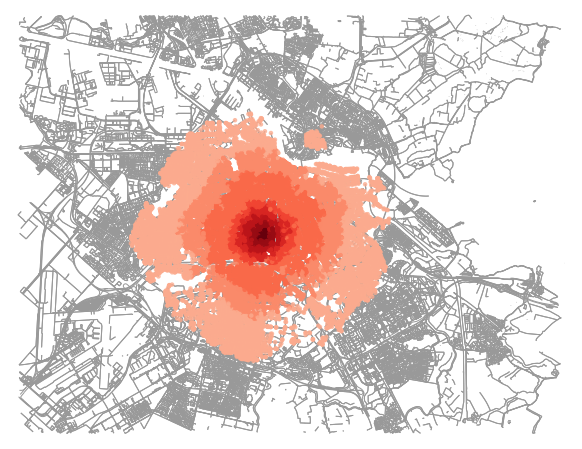

In [20]:
# color the nodes according to isochrone then plot the street network
node_colors = {}
for trip_time, color in zip(sorted(trip_times, reverse=True), iso_colors):
    subgraph = nx.ego_graph(G, center_node, radius=trip_time, distance='time')
    for node in subgraph.nodes():
        node_colors[node] = color
nc = [node_colors[node] if node in node_colors else 'none' for node in G.nodes()]
ns = [20 if node in node_colors else 0 for node in G.nodes()]
fig, ax = ox.plot_graph(G, fig_height=8, node_color=nc, node_size=ns, node_alpha=0.8, node_zorder=2)

In [21]:
# what sized area does our network cover in square meters?
G_proj = ox.project_graph(G)
nodes_proj = ox.graph_to_gdfs(G_proj, edges=False)
graph_area_m = nodes_proj.unary_union.convex_hull.area
graph_area_m

1406031443.7661273

In [22]:
# show some basic stats about the network
ox.basic_stats(G_proj, area=graph_area_m, clean_intersects=True, circuity_dist='euclidean')

{'circuity_avg': 1.0960541481608563,
 'clean_intersection_count': 28725,
 'clean_intersection_density_km': 20.429841827049483,
 'edge_density_km': 9473.446250477627,
 'edge_length_avg': 113.7709653390492,
 'edge_length_total': 13319963.308999863,
 'intersection_count': 39884,
 'intersection_density_km': 28.366364192516677,
 'k_avg': 4.758840744654906,
 'm': 117077,
 'n': 49204,
 'node_density_km': 34.99494994806415,
 'self_loop_proportion': 0.009207615500909658,
 'street_density_km': 5658.35540326892,
 'street_length_avg': 117.04218696854778,
 'street_length_total': 7955825.617000067,
 'street_segments_count': 67974,
 'streets_per_node_avg': 2.7513007072595723,
 'streets_per_node_counts': {0: 0,
  1: 9320,
  2: 611,
  3: 32423,
  4: 6697,
  5: 144,
  6: 8,
  7: 0,
  8: 1},
 'streets_per_node_proportion': {0: 0.0,
  1: 0.18941549467522967,
  2: 0.012417689618730184,
  3: 0.6589504918299325,
  4: 0.1361068205836924,
  5: 0.002926591334037883,
  6: 0.00016258840744654907,
  7: 0.0,
  8: 2

In [25]:
# edge closeness centrality: convert graph to line graph so edges become nodes and vice versa
edge_centrality = nx.closeness_centrality(nx.line_graph(G))

NetworkXNotImplemented: not implemented for multigraph type